## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [1]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
import torch_cae_multilevel_V4 as net
import ResNet as tnet
import utils

In [12]:
#helper functions

def check_pixel_level_loss(d1, d2, tol, device, w=0.5):
    """
    :param d1: data 1
    :param d2: data 2
    :param tol: a float, represent the tolerance
    :param device: device
    :param w: loss = w * mse_loss + (1 - w) * max_loss
    :return: a boolean value, if error satisfies the tolerance,
             a torch tensor of overall loss distribution,
             and a boolean torch tensor
    """
    assert isinstance(tol, float), print('tol should be a float!')

    loss1 = torch.mean((d1 - d2)**2, dim=0, keepdim=True)
    loss2 = torch.max((d1 - d2)**2, dim=0, keepdim=True)[0]
    loss = w * loss1 + (1 - w) * loss2
    loss_summary = apply_local_op(loss, device).squeeze()

    return loss_summary.max() <= tol, loss_summary, loss_summary <= tol

def obtain_data_at_current_level(data, n_levels, level,average = True):
    """ goes from n_levels to level"""
    for i in range(n_levels - level - 1):
        data = apply_local_op(data, 'cpu', ave=average)
    return data

def decrease_to_size(data, level,average = True):
    """ goes from n_levels to level"""
    current_size = data.shape[-1]
#     print("current_size = ", current_size)
    if(current_size<= level):
        return data
    while(current_size > level):
        data = apply_local_op(data.float(), 'cpu', ave=average)
        current_size = data.shape[-1]
#         print("current_size = ", current_size)
    return data
    
def apply_local_op(data, device, mode='conv', ave=True):
    """
    :param data: data to be processed
    :param device: which device is the data placed in?
    :param mode: string, 'conv' or 'deconv'
    :param ave: if to use local average or sample the center
    :return: processed data
    """
    in_channels, out_channels = 1,1#, _, _ = data.size()
#     print("data.size() = ", data.size())
    n = min(in_channels, out_channels)
    if mode == 'conv':
        op = torch.nn.Conv2d(out_channels, out_channels, 2, stride=2, padding=0).to(device)
    elif mode == 'deconv':
        op = torch.nn.ConvTranspose2d(out_channels, out_channels, 3, stride=2, padding=0).to(device)
    else:
        raise ValueError('mode can only be conv or deconv!')
    op.weight.data = torch.zeros(op.weight.data.size()).to(device)
    op.bias.data = torch.zeros(op.bias.data.size()).to(device)

    for i in range(n):
        if mode == 'conv':
            if ave:
                op.weight.data[i, i, :, :] = torch.ones(op.weight.data[i, i, :, :].size()).to(device) / 4
            else:
                op.weight.data[i, i, 1, 1] = torch.ones(op.weight.data[i, i, 1, 1].size()).to(device)
        elif mode == 'deconv':
            op.weight.data[i, i, :, :] = torch.ones(op.weight.data[i, i, :, :].size()).to(device) / 4
            op.weight.data[i, i, 0, 1] += 1 / 4
            op.weight.data[i, i, 1, 0] += 1 / 4
            op.weight.data[i, i, 1, 2] += 1 / 4
            op.weight.data[i, i, 2, 1] += 1 / 4
            op.weight.data[i, i, 1, 1] += 1 / 4
            op.weight.data[i, i, 1, 1] += 1 / 2

    # make them non-trainable
    for param in op.parameters():
        param.requires_grad = False

    return op(data)

def apply_mask(data, mask, mask_type='resolved', width=1):
    """
    :param data: data to be processed
    :param mask: mask, a 2D torch tensor of 0s and 1s
    :param mask_type: resolved map or unresolved map
    :param width: int, specify how large the region is
    :return: a 4D torch tensor represents masked data
    """
    if not isinstance(width, int):
        raise ValueError('width should be a positive integer!')

    # convert to unresolved mask
    if mask_type == 'resolved':
        mask = 1 - mask
        # print(mask)
    elif mask_type == 'unresolved':
        mask = mask
    else:
        raise ValueError('mask_type could only be resolved or unresolved!')

#     # expansion
#     dx = [i for i in range(-width, width+1)]
#     dy = [i for i in range(-width, width+1)]
#     m, n = mask.size()
#     for c in mask.nonzero():
#         x, y = int(c[0]), int(c[1])
#         for i in range(2*width+1):
#             for j in range(2*width+1):
#                 if 0 <= x + dx[i] < m and 0 <= y + dy[j] < n:
#                     mask[x + dx[i], y + dy[j]] = 1

    # apply
#     print("data shape = ", data.shape)
#     print("mask.unsqueeze(0).unsqueeze(0).float() shape = ", mask.unsqueeze(0).unsqueeze(0).float().shape)
    masked_data = data * mask.unsqueeze(0).unsqueeze(0).float()
    return masked_data

def grow(data, size_full=128):
#     print("growing")
    data = make_size_4(data)
    n_points, _, size_small, _ = data.shape
    divide = size_full // size_small

    averaged_full = np.zeros((n_points, size_full,size_full))
    for i in range(size_small):
        for j in range(size_small):
            repeated = np.repeat(np.repeat(data[:,0,i,j].reshape(n_points,1,1), divide, axis = 1), divide, axis = 2)
            averaged_full[:,i*divide:(i+1)*divide, j*divide:(j+1)*divide] = repeated
    return averaged_full

def make_next_layer(data_big, data_small, unresolved, size = 128):
    '''determine the next level make up with new map, old map and unresolved 
    All tensors
    '''
#     print('making next layer')
    multi = grow(data_big, size) * (1-grow(unresolved, size)) + grow(data_small, size)*grow(unresolved, size)
    return multi

def data_of_size(data,size):
    return decrease_to_size(torch.tensor(data).unsqueeze(1), size)

def MSE(data1, data2, size_small, tol = 1e-5, size = 128):
#     print("data1 shape = ", data1.shape)
#     print("data2 shape = ", data2.shape)
    data1 = make_size_4(data1)
    data2 = make_size_4(data2)
    mse = np.mean((grow(data1, size) - grow(data2, size))**2, axis = 0)
    
#     print("mse shape = ", mse.shape)
    mse_smaller = decrease_to_size(torch.tensor(mse).unsqueeze(0).unsqueeze(0), size_small)
    
    loss_summary = mse_smaller[0,0]
#     print("max_loss = ", loss_summary.max())
    
    return loss_summary.max() <= tol, loss_summary, loss_summary <= tol

def make_size_4(data):
    data = torch.tensor(data)
    if len(data.shape) == 2:
        data = data.unsqueeze(0)
    if len(data.shape) == 3:
        data = data.unsqueeze(1)
    assert (len(data.shape) == 4)
    return data

## MrCAE

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

<ipython-input-12-415e57eac121>:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)


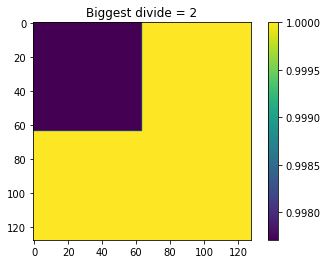

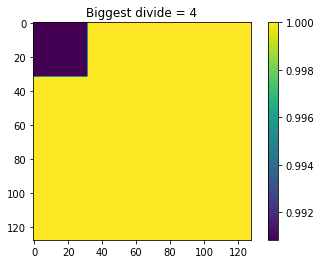

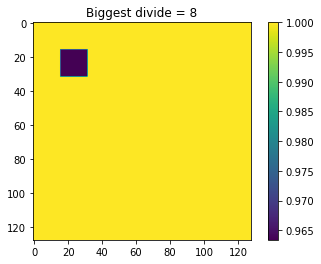

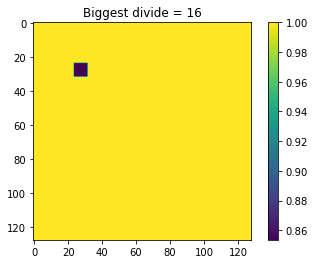

In [15]:
# init model & load data
data_path = '../data/toy2'
model_path = '../model/toy2'
result_path = '../result/toy2/'

full_data_path = os.path.join(data_path, 'data.npy')
data = np.load(full_data_path)


#predict 2x2 and graph
current_size = 2
next_size = current_size * 2
resolved = False
current_data = grow(data_of_size(data,current_size))
next_data = grow(data_of_size(data,next_size))

# print("current_data shape = ", current_data.shape)
plt.imshow(current_data[0])
plt.title("Biggest divide = "+str(current_size))
plt.colorbar()
plt.show()
resolved, loss, unresolved = MSE(current_data, next_data, current_size)
while resolved == False:

    current_data = make_next_layer(next_data, current_data, unresolved)
    current_size *=2
    next_size = current_size * 2
    next_data = grow(data_of_size(data,next_size))
#     print("current_size= ", current_size)
    plt.imshow(current_data[0])
    plt.title("Biggest divide = "+str(current_size))
    plt.colorbar()
    plt.show()
    
    resolved, loss, unresolved = MSE(current_data, next_data, current_size)




In [7]:
loss

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

current_size=  32


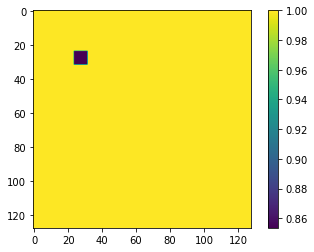

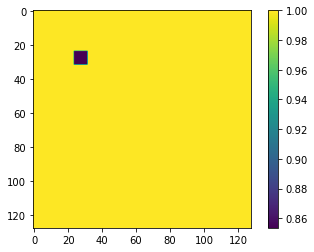

current_size =  128
current_size =  64
current_size =  32
current_size =  16
growing


<ipython-input-2-528c689a7a60>:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)


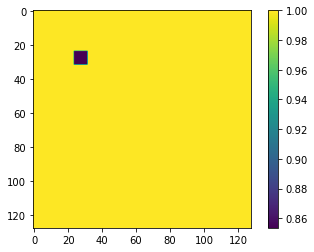

In [11]:
print("current_size= ", current_size)
plt.imshow(current_data[0])
plt.colorbar()
plt.show()

plt.imshow(data[0])
plt.colorbar()
plt.show()

plt.imshow(grow(data_of_size(data,16))[0])
plt.colorbar()
plt.show()

In [4]:
resolved, loss, unresolved = MSE(averaged_data, all_data_4x4, 2)

NameError: name 'averaged_data' is not defined

In [ ]:
averaged_data = make_next_layer(all_data_4x4, averaged_data, unresolved)
plt.imshow(averaged_data[0])
plt.colorbar()
plt.show()

In [ ]:
loss

In [ ]:
mse = np.mean((grow(all_data_2x2, 128) - grow(all_data_4x4, 128))**2, axis = 0)
print(mse.shape)
plt.imshow(mse)
plt.colorbar()
plt.show()

mse_2x2 = decrease_to_size(torch.tensor(mse).unsqueeze(0).unsqueeze(0), 2)
plt.imshow(mse_2x2[0,0])
plt.colorbar()
plt.show()

In [ ]:
tol = 1e-5
loss_summary = mse_2x2[0,0]
resolved, loss, unresolved = loss_summary.max() <= tol, loss_summary, loss_summary <= tol
print(unresolved)
print(loss_summary)

In [ ]:
multi = grow(all_data_2x2, 128) * (1-grow(unresolved, 128))

In [ ]:
multi_4x4 = grow(all_data_4x4, 128) * (1-grow(unresolved, 128)) + grow(all_data_2x2, 128)*grow(unresolved, 128)

In [ ]:
# multi.shape
plt.imshow(all_data_2x2[0,0])
plt.colorbar()
plt.show()

plt.imshow(multi[0,])
plt.colorbar()
plt.show()

In [ ]:
# mse = np.mean((grow(torch.tensor(all_data_8x8), 128) - grow(torch.tensor(multi), 128))**2, axis = 0)
# print(mse.shape)
# plt.imshow(mse)
# plt.colorbar()
# plt.show()

mse_4x4 = decrease_to_size(torch.tensor(mse).unsqueeze(0).unsqueeze(0), 4)
plt.imshow(mse_4x4[0,0])
plt.colorbar()
plt.show()



In [ ]:
tol = 1e-5
loss_summary = mse_4x4[0,0]
resolved, loss, unresolved = loss_summary.max() <= tol, loss_summary, loss_summary <= tol

unresolved = torch.tensor(unresolved)
print(unresolved)
print(loss_summary)

In [ ]:
multi_8x8 = grow(torch.tensor(all_data_8x8), 128) * (1-grow(unresolved, 128)) + grow(torch.tensor(multi_4x4), 128)*grow(unresolved, 128)

In [ ]:
plt.imshow(multi_8x8[0])
plt.colorbar()
plt.show()

In [ ]:
resolve_map = torch.tensor([[1,1,1],[1,0,1],[1,1,1]])

mapped = apply_mask(all_data, resolve_map)
print(mapped.shape)

plt.imshow(mapped[0,0])
plt.colorbar()
plt.show()

In [ ]:
seven = net.apply_local_op(mapped, 'cpu', mode='deconv', ave=True)

plt.imshow(seven[0,0])

In [ ]:
# training
archs = [[1]]#,[1,3,5,7]]
tols = [0.001]#, 0.0005]#, 0.0001]
# net.train_net(archs=archs, dataset=dataset, max_epoch=3000, batch_size=350, 
#               tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
#               result_path=result_path, std=0.01, verbose=3)

n_levels = 5
activation = torch.nn.Sequential()
use_maps = True
std = 0.01
verbose = 3
max_epoch=100
lr = 1e-3
tol = 0.001

model = net.CAE(n_levels=n_levels, activation=activation, use_maps=use_maps)

# try:
#     model_space = torch.load(os.path.join(model_path, 'model_L0_0.pt'))
# except:
#     print("training new stage")
#     model_space = net.train_net_one_stage(mode=1, n_filters=1, dataset=dataset, max_epoch=3000, batch_size=350, result_path = result_path,
#                         load_model=None, tol=tols[0],std=0.01,  model_path=model_path, verbose=3)

In [ ]:
model.deeper_op(std=std)
if verbose > 1:
            print('model layers: ')
            print(list(model._modules.keys()))
val_losses, best_val_loss, mset = model.train_arch(dataset, max_epoch=max_epoch, batch_size=300,
                                                           lr=lr, tol=tol, verbose=verbose, w=0.5)
        

In [ ]:
print(model.cur_level)
# all_data = dataset.obtain_data_at_current_level_all(model.cur_level)

predicted,_,_,_ = model(all_data,model.cur_level)
plt.imshow(predicted[0,0].detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(all_data[0,0].detach().numpy())
plt.colorbar()
plt.show()

In [ ]:
n_filters = 1
batch_size = 250
model.wider_op(n_filters=n_filters, std=std)
# if verbose > 1:
print('model layers: ')
print(list(model._modules.keys()))
val_losses, best_val_loss, mset = model.train_arch(dataset, max_epoch=max_epoch, batch_size=batch_size,
                                                           lr=lr, tol=tol, verbose=verbose, w=0.5)

In [ ]:
print(model.cur_level)
# all_data = dataset.obtain_data_at_current_level_all(model.cur_level)

predicted,_,_,_ = model(all_data,model.cur_level)
plt.imshow(predicted[0,0].detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(all_data[0,0].detach().numpy())
plt.colorbar()
plt.show()

In [ ]:

print(model_space.cur_level)
all_data = dataset.obtain_data_at_current_level_all(model_space.cur_level)
print(all_data.shape)
train_data, val_data, test_data =dataset.obtain_data_at_current_level(model_space.cur_level)
encoded = model_space.encode(all_data, model_space.cur_level)
print(encoded.shape)
train_encoded = model_space.encode(train_data, model_space.cur_level).reshape((1, len(train_data), len(encoded[0,0])**2))
val_encoded = model_space.encode(val_data, model_space.cur_level).reshape((1, len(val_data), len(encoded[0,0])**2))
test_encoded = model_space.encode(test_data, model_space.cur_level).reshape((1, len(test_data), len(encoded[0,0])**2))

print(train_encoded.shape)
print(val_encoded.shape)
print(test_encoded.shape)

In [ ]:
print(encoded.shape)
plt.imshow(encoded[500,0].detach().numpy())
plt.colorbar()

In [ ]:
#make more training points, more and less timesteps per
n_timesteps_per_point = len(test_encoded[0])
print(n_timesteps_per_point)
total_time_points = len(train_encoded[0])
n_points = total_time_points//n_timesteps_per_point
print(n_points)
train_encoded_more = torch.cat(
    (train_encoded[:,:n_timesteps_per_point], train_encoded[:,n_timesteps_per_point:2*n_timesteps_per_point]), 0)
print(train_encoded_more.shape)
for i in range(2,n_points):
    train_encoded_more = torch.cat(
    (train_encoded_more, train_encoded[:,(i*n_timesteps_per_point):((i+1)*n_timesteps_per_point)]), 0)

print(train_encoded_more.shape)

In [ ]:
#getting time inputs
# t = np.linspace(0, 8*np.pi, 500)
k = 0                         # model index: should be in {0, 2, ..., 10}
dt = 1#t[1] - t[0]              # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'toy1_longer'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epochs = 10000            # the maximum training epoch 
batch_size = 320              # training batch size
min_k = 7
max_k = 8

print(val_encoded.shape)
_,n_steps, total_dim= val_encoded.shape
n_steps = n_steps - 1
# total_dim = n_per_dim **2
print("total_dim = ", total_dim)
arch = [total_dim, 128, 128, 128, total_dim] 

# global const
n_forward = 5
step_size = 2**k

criterion = torch.nn.MSELoss(reduction='none')
# print(dt)
# dataset = tnet.DataSet(train_encoded, val_encoded, test_encoded, dt, step_size, n_forward)

In [ ]:
#do time training 
time_models = list()
step_sizes = list()
for k in range(min_k, max_k):
    print("k = ", k)
    step_size = 2**k
    step_sizes.append(step_size)
    dataset = tnet.DataSet(train_encoded, val_encoded, test_encoded, dt, step_size, n_forward)#tnet.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)
#     print(dataset.train_x.shape)
    model_name = 'model_D{}_noise{}_0.pt'.format(step_size, noise)
    model_path_this = os.path.join(model_path, model_name)

    # create/load model object
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model_time = torch.load(model_path_this, map_location=device)
        model_time.device = device
    except:
        print('create model {} ...'.format(model_name))
        print('dt = ', dt)
        model_time = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

    # training
    model_time.train_net(dataset, max_epoch=max_epochs, batch_size=batch_size, lr=lr,
                    model_path=os.path.join(model_path, model_name))
    
# load models
# for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    time_models.append(torch.load(model_path_this, map_location='cpu'))
    
# fix model consistencies trained on gpus (optional)
for model in time_models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

In [ ]:
val_encoded.shape

In [ ]:
# # uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(models):
    start = time.time()
    print(val_encoded.shape)
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).float(), n_steps=n_steps)
    print("y_preds.shape =", y_preds.shape)
    end = time.time()
    times.append(end - start)
    print('criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape =', criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds).mean(-1).shape )
    preds_mse.append(criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds).mean(-1))
    print(len(preds_mse))
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
print(colors)
for k in range(max_k-min_k):
    err = preds_mse[k]
    print('err.shape = ', err.shape)
    mean = err[0].detach().numpy()
    rgb = next(colors)
    print(mean.shape)
#     print(len(t))
#     print(t)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])
# plt.xlim([0, len(t)])
    

In [ ]:
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
print(colors)
for k in range(max_k-min_k):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
#     print(np.mean(mean[::step_every]))
    rgb = next(colors)
    step_every = step_sizes[k]
    t = range(len(mean))
    plt.semilogy(t[::step_every], mean[::step_every], linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])

In [ ]:
#need to predict encoded dta in time and then decode

print(n_steps)
train_preds_time = model.uni_scale_forecast(torch.tensor(train_encoded[:, 0, :]).float(), n_steps=len(train_encoded[0])-1)
val_preds_time = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).float(), n_steps=n_steps)
test_preds_time = model.uni_scale_forecast(torch.tensor(test_encoded[:, 0, :]).float(), n_steps=len(test_encoded[0])-1)
print(criterion(torch.tensor(train_encoded[:, 1:, :]).float(), train_preds_time).mean(-1).mean())
print(criterion(torch.tensor(val_encoded[:, 1:, :]).float(), val_preds_time).mean(-1).mean())
print(criterion(torch.tensor(test_encoded[:, 1:, :]).float(), test_preds_time).mean(-1).mean())
# train_encoded

#decode
print(train_preds_time.reshape((3499,3,3)).shape)
to_decode_train = torch.tensor(train_preds_time.reshape((3499,3,3))).unsqueeze(1).float()
train_decoded = model_space.decode(to_decode_train, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))
print(train_decoded.shape)

print(val_preds_time.shape)
to_decode_val = torch.tensor(val_preds_time.reshape((999,3,3))).unsqueeze(1).float()
val_decoded = model_space.decode(to_decode_val, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))

print(test_preds_time.shape)
to_decode_test = torch.tensor(test_preds_time.reshape((len(test_preds_time[0]),3,3)).unsqueeze(1).float())
test_decoded = model_space.decode(to_decode_test, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))
print(test_decoded.shape)

In [ ]:
train_preds_time.shape
plt.imshow(train_preds_time[0,500].reshape(3,3))
plt.colorbar()

In [ ]:
print(train_decoded.shape)
plt.imshow(train_decoded[499,0].detach().numpy())
plt.colorbar()
plt.show()
print(train_data.shape)
plt.imshow(train_data[21,0].detach().numpy())
plt.colorbar()
plt.show()

mse =criterion(torch.tensor(train_decoded[:]).float(), train_data[:-1,].float()).mean( axis=(1, 2,3))
print(mse.shape)
plt.semilogy(mse)

In [ ]:

print(test_preds_time.shape)
mse =criterion(torch.tensor(val_decoded[:]).float(), val_data[:-1,].float()).mean( axis=(1,2,3))
print(mse.shape)
plt.semilogy(mse)
plt.title("val error of decoded")
plt.show()

print(test_preds_time.shape)
mse =criterion(torch.tensor(test_decoded[:]).float(), test_data[:-1,].float()).mean( axis=(1,2,3))
print(mse.shape)
plt.semilogy(mse)
plt.title("test error of decoded")

In [ ]:
utils.animate(test_decoded.detach().numpy(), os.path.join(result_path, 'decoded_test_7x7.gif'))

In [ ]:
# torch.tensor(train_decoded[:]).float(), train_data[:-1,].float())
print(train_decoded.shape)
tol = 0.1
fully_resolved, loss, resolved_map = net.check_pixel_level_loss(train_decoded[:499].float(), train_data[1:500,].float(), tol=tol, device = 'cpu')

In [ ]:
print(loss.shape)
plt.imshow(loss.detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(resolved_map.detach().numpy())
plt.colorbar()
plt.show()